### Project Objectives

Given real life Amazon Employee data from 2010 and 2011 (source: Kaggle), we aim to use a CatBoost Classifier to determine whether an employee should be granted access to resources.

In [1]:
from pyforest import*
lazy_imports()

['import statistics',
 'import awswrangler as wr',
 'import lightgbm as lgb',
 'import seaborn as sns',
 'import sklearn',
 'from sklearn.model_selection import train_test_split',
 'from pathlib import Path',
 'import bokeh',
 'import pydot',
 'import altair as alt',
 'import re',
 'import matplotlib.pyplot as plt',
 'import sys',
 'from openpyxl import load_workbook',
 'import numpy as np',
 'import dash',
 'import xgboost as xgb',
 'import pandas as pd',
 'import gensim',
 'import tqdm',
 'import spacy',
 'from sklearn.preprocessing import OneHotEncoder',
 'from sklearn.ensemble import RandomForestClassifier',
 'import os',
 'from sklearn.manifold import TSNE',
 'import pickle',
 'from sklearn.ensemble import GradientBoostingClassifier',
 'from pyspark import SparkContext',
 'from sklearn.ensemble import RandomForestRegressor',
 'from sklearn.ensemble import GradientBoostingRegressor',
 'import matplotlib as mpl',
 'import plotly as py',
 'from sklearn.feature_extraction.text import 

In [2]:
training_set = pd.read_csv("amazontrain.csv")
test_set = pd.read_csv("amazontest.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
training_set.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
test_set.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


### Exploratory Data Analysis

In [5]:
training_set.shape

(32769, 10)

In [6]:
test_set.shape

(58921, 10)

In [7]:
training_set.apply(lambda x: len(x.unique()))

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [8]:
training_set["MGR_ID"].value_counts()

770      152
2270      99
2594      82
1350      71
2014      67
        ... 
1940       1
8087       1
22526      1
34948      1
58677      1
Name: MGR_ID, Length: 4243, dtype: int64

<IPython.core.display.Javascript object>

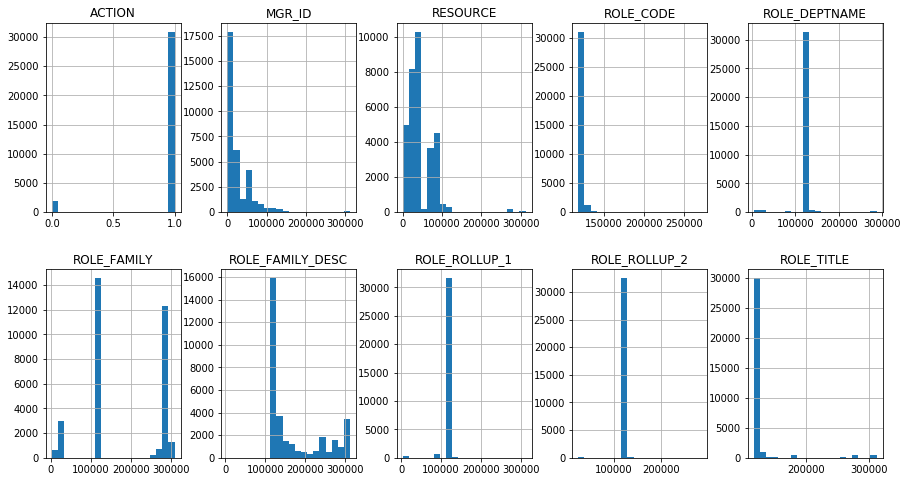

In [9]:
training_set.hist(bins = 20, figsize = (15, 8), layout = (2, 5))
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

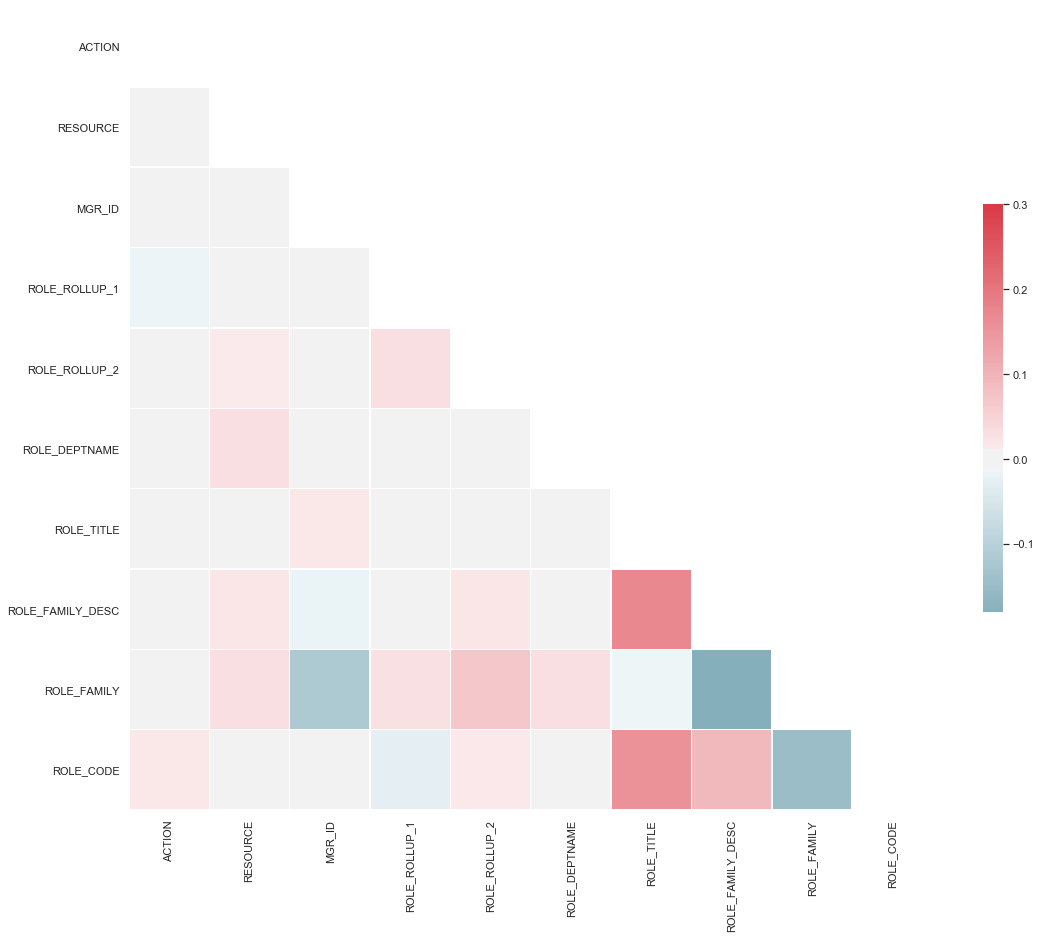

In [10]:
sns.set(style = "white")

corr = training_set.corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (18, 15))

cmap = sns.diverging_palette(h_neg = 220, h_pos = 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
           square = True, linewidth = 0.5, cbar_kws = {"shrink": 0.5})

### Building the Model

In [11]:
y = training_set["ACTION"]
X = training_set.drop("ACTION", axis = 1)
X_test = test_set.drop("id", axis = 1)

In [12]:
from sklearn.model_selection import train_test_split
import time
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [13]:
from catboost import CatBoostClassifier

parameters = {"loss_function": "Logloss",
             "eval_metric": "AUC",
             "verbose": 200,
             "random_seed": 2}

cat_model1 = CatBoostClassifier(**parameters)
cat_model1.fit(X_train, y_train,
              eval_set = (X_valid, y_valid),
              use_best_model = True);

Learning rate set to 0.069882
0:	test: 0.5606827	best: 0.5606827 (0)	total: 77.6ms	remaining: 1m 17s
200:	test: 0.8101079	best: 0.8104065 (198)	total: 3.72s	remaining: 14.8s
400:	test: 0.8261822	best: 0.8261822 (400)	total: 6.76s	remaining: 10.1s
600:	test: 0.8380134	best: 0.8380134 (600)	total: 9.86s	remaining: 6.55s
800:	test: 0.8440663	best: 0.8442704 (795)	total: 12.8s	remaining: 3.18s
999:	test: 0.8474796	best: 0.8476585 (976)	total: 15.7s	remaining: 0us

bestTest = 0.8476585192
bestIteration = 976

Shrink model to first 977 iterations.


In [14]:
# We do not want CatBoost to treat categorical values like they are numerical
categorical_vars = list(range(X.shape[1]))
print(categorical_vars)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [15]:
parameters = {"loss_function": "Logloss",
             "eval_metric": "AUC", 
              "cat_features": categorical_vars,
             "verbose": 200,
             "random_seed": 2}

cat_model2 = CatBoostClassifier(**parameters)
cat_model2.fit(X_train, y_train,
              eval_set = (X_valid, y_valid),
              use_best_model = True);

Learning rate set to 0.069882
0:	test: 0.5000000	best: 0.5000000 (0)	total: 25.6ms	remaining: 25.6s
200:	test: 0.8962532	best: 0.8962532 (200)	total: 10.7s	remaining: 42.6s
400:	test: 0.8976345	best: 0.8977378 (385)	total: 22.9s	remaining: 34.2s
600:	test: 0.8969336	best: 0.8977378 (385)	total: 34.9s	remaining: 23.2s
800:	test: 0.8959279	best: 0.8977378 (385)	total: 50.3s	remaining: 12.5s
999:	test: 0.8936389	best: 0.8977378 (385)	total: 1m 5s	remaining: 0us

bestTest = 0.8977378388
bestIteration = 385

Shrink model to first 386 iterations.


### Model Evaluation

In [16]:
from catboost import cv
from catboost import Pool

parameters = {"loss_function": "Logloss",
             "eval_metric": "AUC",
             "verbose": 200,
             "random_seed": 2}

total_training_data = Pool(data = X, label = y,
                          cat_features = categorical_vars)

scores = cv(pool = total_training_data, params = parameters,
           fold_count = 5, seed = 1, shuffle = True,
           stratified = True)

0:	test: 0.6081427	best: 0.6081427 (0)	total: 482ms	remaining: 8m 1s
200:	test: 0.8889671	best: 0.8889671 (200)	total: 1m 16s	remaining: 5m 2s
400:	test: 0.8930906	best: 0.8930906 (400)	total: 2m 40s	remaining: 3m 59s
600:	test: 0.8951978	best: 0.8952245 (596)	total: 4m 5s	remaining: 2m 42s
800:	test: 0.8961106	best: 0.8961106 (800)	total: 5m 30s	remaining: 1m 21s
999:	test: 0.8964559	best: 0.8965570 (976)	total: 6m 45s	remaining: 0us


In [17]:
feature_ranks = cat_model2.get_feature_importance(prettified = True)
feature_ranks

,Feature Id,Importances
0,RESOURCE,24.023303
1,ROLE_DEPTNAME,18.225974
2,MGR_ID,14.055719
3,ROLE_ROLLUP_2,10.993372
4,ROLE_FAMILY_DESC,7.795007
5,ROLE_CODE,7.670701
6,ROLE_FAMILY,6.987140
7,ROLE_ROLLUP_1,5.139125
8,ROLE_TITLE,5.109660


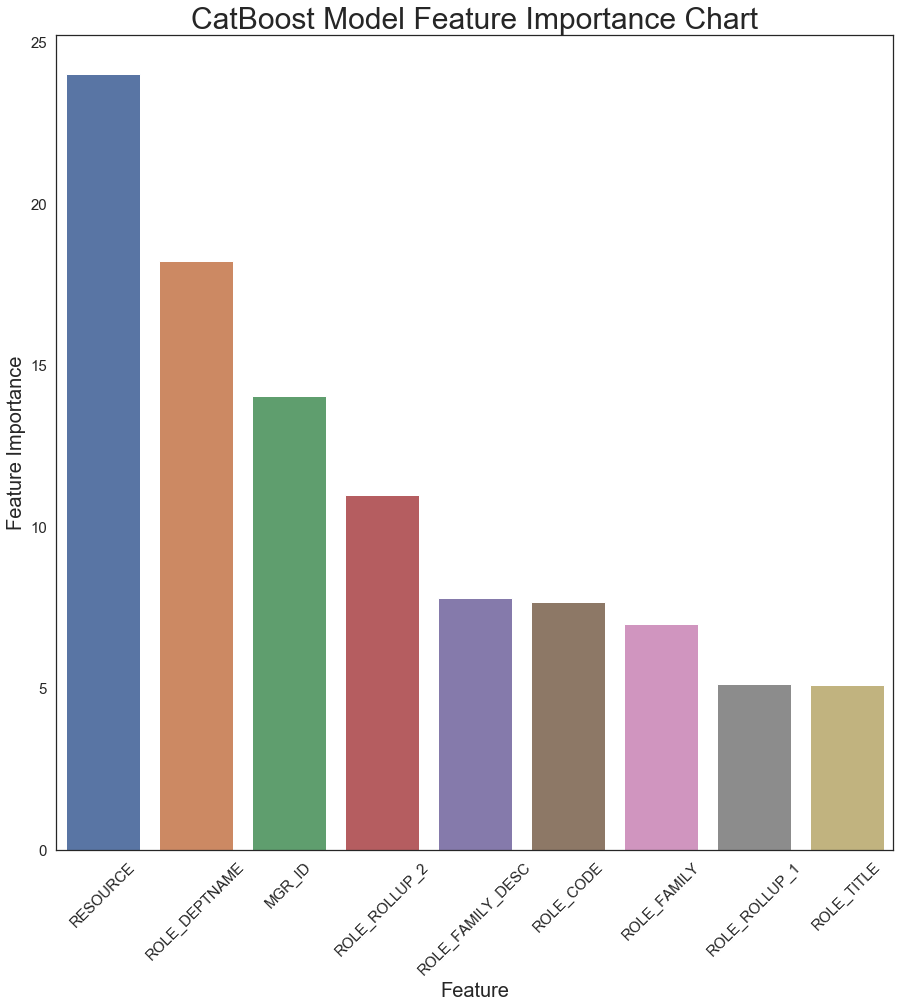

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize = (15, 15))
sns.barplot(x = feature_ranks["Feature Id"], y = feature_ranks["Importances"],
            orient = "V")
plt.title("CatBoost Model Feature Importance Chart", fontsize = 30)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)
plt.xlabel("Feature", fontsize = 20)
plt.ylabel("Feature Importance", fontsize = 20)
plt.show()

In [19]:
prediction_probs = cat_model2.predict_proba(X_test)
cat_pred = cat_model2.predict(X_test)
prediction_probs, cat_pred

(array([[0.56330929, 0.43669071],
        [0.00664134, 0.99335866],
        [0.01307346, 0.98692654],
        ...,
        [0.00692288, 0.99307712],
        [0.02967186, 0.97032814],
        [0.01152089, 0.98847911]]),
 array([0, 1, 1, ..., 1, 1, 1]))

In [20]:
cat_model2.score(X_valid, y_valid)

0.9569144391553766

### Addressing Data Imbalance

In [21]:
training_set["ACTION"].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

In [22]:
from sklearn import neighbors
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [23]:
parameters = {"loss_function": "Logloss",
             "eval_metric": "AUC", 
              "cat_features": categorical_vars,
             "verbose": 200,
             "random_seed": 2}

cat_model3 = CatBoostClassifier(**parameters)
cat_model3.fit(X_train, y_train,
              eval_set = (X_valid, y_valid),
              use_best_model = True);

Learning rate set to 0.08172
0:	test: 0.7271578	best: 0.7271578 (0)	total: 85.9ms	remaining: 1m 25s
200:	test: 0.9702590	best: 0.9703146 (199)	total: 21.8s	remaining: 1m 26s
400:	test: 0.9711131	best: 0.9712466 (383)	total: 44.2s	remaining: 1m 6s
600:	test: 0.9712238	best: 0.9713635 (594)	total: 1m 6s	remaining: 43.9s
800:	test: 0.9725347	best: 0.9728189 (770)	total: 1m 28s	remaining: 21.9s
999:	test: 0.9741993	best: 0.9743624 (996)	total: 1m 51s	remaining: 0us

bestTest = 0.9743624087
bestIteration = 996

Shrink model to first 997 iterations.


In [24]:
cat_model3.score(X_valid, y_valid)

0.9794946905895277